# Calculate raw STRFs for one example cells of Ntsr1Cre_2019_0008

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle

## Load data

In [8]:
m = 'Ntsr1Cre_2019_0008'
s = 5
e = 8

In [9]:
with h5py.File('./data/'+str(m)+'_s0'+str(s)+'e0'+str(e)+'_binned.h5', 'r') as f:
    response = np.array(f['response']) 
    stimulus = np.array(f['stimulus'])
    tranges = np.array(f['tranges'])

In [10]:
with open('./data/spiketimes_'+str(m)+'_s0'+str(s)+'e0'+str(e)+'.txt', "rb") as fp:   # Unpickling
    spiketimes = pickle.load(fp)

In [11]:
print('stimulus shape: ',stimulus.shape)
print('response shape: ',response.shape)
print('number of spiketimes first cell: ', spiketimes[0].shape[0])

stimulus shape:  (54000, 16, 25)
response shape:  (6, 54000)
number of spiketimes first cell:  27768


In [12]:
(8*180*30) + (9*40*30)

54000

* 54000 frames 
* spatial resolution downsampled from 424x264 to 16x25
* 6 units after spikesorting for this session
* number of spike times varies

In [13]:
# sanity check if first and last spike falls into tranges
print('First spike time cell 1: ',spiketimes[0][0])
print('Last spike time cell 1: ',spiketimes[0][-1])

First spike time cell 1:  61.251416
Last spike time cell 1:  1864.667033


In [14]:
#units = [19, 21, 27, 48, 54, 58]
units = [48]

## Frame triggers (estimated)

Stimulus time ranges:

In [15]:
tranges

array([[  61.214 ,  101.2786],
       [ 101.294 ,  281.6264],
       [ 281.6485,  321.7258],
       [ 321.727 ,  502.0451],
       [ 502.048 ,  542.1253],
       [ 542.16  ,  722.497 ],
       [ 722.481 ,  762.5583],
       [ 762.5595,  942.9049],
       [ 942.914 ,  982.9913],
       [ 982.9925, 1163.3285],
       [1163.347 , 1203.4243],
       [1203.4255, 1383.7662],
       [1383.7795, 1423.8568],
       [1423.8585, 1604.2045],
       [1604.1795, 1644.2568],
       [1644.258 , 1824.602 ],
       [1824.612 , 1864.6893]])

Select time range:

In [16]:
stim_tranges = [tranges[0][0], tranges[-1][1]]
stim_tranges

[61.214, 1864.6893]

Select the whole 30 min of experiment.

In [17]:
# estimate frame triggers for full 30 min experiment:
frame_triggers = np.linspace(stim_tranges[0], stim_tranges[1], stimulus.shape[0])

In [18]:
frame_triggers.shape

(54000,)

## Training blocks

In [19]:
stim_ids = np.array([0,1,0,2,0,3,0,4,0,5,0,6,0,7,0,8,0]) # will be made available through table Stimulus()
stim_ids

array([0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0, 7, 0, 8, 0])

In [20]:
tranges_train = tranges[np.where(stim_ids!=0)]
tranges_train

array([[ 101.294 ,  281.6264],
       [ 321.727 ,  502.0451],
       [ 542.16  ,  722.497 ],
       [ 762.5595,  942.9049],
       [ 982.9925, 1163.3285],
       [1203.4255, 1383.7662],
       [1423.8585, 1604.2045],
       [1644.258 , 1824.602 ]])

In [21]:
np.diff(tranges_train)

array([[180.3324],
       [180.3181],
       [180.337 ],
       [180.3454],
       [180.336 ],
       [180.3407],
       [180.346 ],
       [180.344 ]])

In [22]:
tranges_train.shape

(8, 2)

* 180 s is the length of each training block
* 8 training blocks were played
* 2 time ranges per training block (start & stop)
* 5400 frames per each training block
* 43200 frames for all 8 training blocks together (8 times 180 times 30)

In [23]:
end = 0
stim_train_l = []
resp_train_l = []
spkt_train_l = []
frtr_train_l = []

# loop through all training blocks and save them as one array (or in lists for spike times)
for i, trange in enumerate(tranges_train):
    start = end+(40*30) # skip test block which is 40 s long
    end = start+(180*30) # 180 s is the length of one training block
    
    # stimulus
    stim_train_l.append(stimulus[start:end,:,:])
    
    # response
    resp_train_l.append(response[:,start:end])
    
    # frame triggers
    frtr_train_l.append(frame_triggers[start:end])
    
    # spiketimes
    # loop through cells
    for cell in range(len(spiketimes)):
        # when list empty at start, first fill it
        if i==0:
            # use actual time ranges here instead of estimated frame triggers -> this could lead to inaccuracies but shouldn't be a problem as soon as I get the actual frame triggers
            spkt_train_l.append(spiketimes[cell][np.where(np.logical_and(spiketimes[cell]>=trange[0], spiketimes[cell]<=trange[1]))])
        else:
            # with every following stimulus block, just add the spiketimes of this block to the cell entry in the list
            new_spkt = spiketimes[cell][np.where(np.logical_and(spiketimes[cell]>=trange[0], spiketimes[cell]<=trange[1]))]
            prev_spkt =  spkt_train_l[cell]
            spkt_train_l[cell] = np.concatenate((prev_spkt,new_spkt))

# convert list to arrays for stimulus and response (spiketimes stay list because of unequal length of arrays per cell)
stim_train = np.vstack(stim_train_l)
resp_train = np.hstack(resp_train_l)
frtr_train = np.hstack(frtr_train_l)

print(stim_train.shape)
print(resp_train.shape)
print(frtr_train.shape)

(43200, 16, 25)
(6, 43200)
(43200,)


* 43200 frames for all 8 training blocks (8 times 180s times 30Hz)
* 6 cells for this experimental session
* 43200 frame triggers because each frame needs a trigger

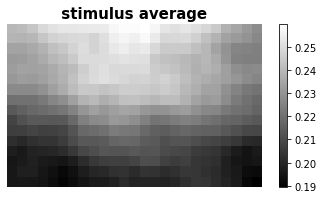

In [25]:
fig, axs = plt.subplots(1,1,figsize=(6,3))
im=axs.imshow((np.mean(stim_train, axis=0)), cmap='gray')
axs.set_axis_off()
axs.set_title(' stimulus average ', weight='bold', fontsize=15)
fig.colorbar(im, ax=axs)

Response train array:

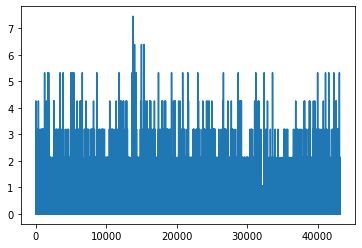

In [26]:
plt.plot(resp_train[1,:])

There is no pattern because the training stimuli are not identical.

# STRF using hmov_train

In [27]:
len_filter = int(1) # 6*33ms=200ms

In [28]:
feq = 30
binwidth = 1/30
200/(binwidth*1000)

6.0

In [29]:
binwidth*6 # in seconds

0.2

Do it for one example cell:

In [30]:
cell_id = 3
spkt = spkt_train_l[cell_id]

Select frames that are previous to a spike:

In [31]:
idxs_frame = []

for spike_time in spkt:
    idx_frame = np.searchsorted(frtr_train, spike_time)-1
    idxs_frame.append(idx_frame)
idxs_frame = np.array(idxs_frame)

Ignore the ones that are too close to the beginning:

In [32]:
idxs_frame = np.delete(idxs_frame, np.argwhere(idxs_frame <= len_filter))

Cut out movie snippets of len filter prior to a spike:

In [33]:
stim_snippets = []

for i in idxs_frame:
    cut_out_3d = stim_train[i-len_filter+1:i+1,:,:]
    stim_snippets.append(cut_out_3d)

In [34]:
print(len(stim_snippets))

3575


In [35]:
stim_snippets[5].shape

(1, 16, 25)

Convert list into 4d array:

In [36]:
all_snippets_as_array = np.stack(stim_snippets, axis=0)

In [37]:
all_snippets_as_array.shape

(3575, 1, 16, 25)

Calculate mean over the first dimension:

In [38]:
STA_3d = np.mean(all_snippets_as_array,0)

In [39]:
STA_3d.shape

(1, 16, 25)

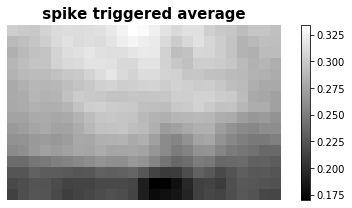

In [40]:
fig, axs = plt.subplots(1,1,figsize=(6,3))
im=axs.imshow(STA_3d[0,:,:], cmap='gray')
axs.set_axis_off()
axs.set_title(' spike triggered average ', weight='bold', fontsize=15)
fig.colorbar(im, ax=axs)
fig.tight_layout()